# Классификация животных на снимках (окружающая среда)

Дообучаем предобученный `ResNet-18` на подмножестве животных из датасета CIFAR-10.
Тематика проекта — мониторинг биоразнообразия: распознаём птиц, кошек, оленей, собак, лягушек и лошадей по фотографиям.
Рабочий план:
1. Скачать датасет и оставить только классы животных.
2. Подготовить пайплайн аугментаций, загрузчиков данных и меток.
3. Дообучить голову предобученного ResNet-18.
4. Посчитать accuracy, классификационный отчёт и матрицу ошибок.
5. Посмотреть несколько предсказаний на тестовых примерах.


In [ ]:
import os, random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

Matplotlib created a temporary cache directory at /var/folders/m3/cdhh8rds5dv4d5dsfnnk882m0000gn/T/matplotlib-l11teriq because the default path (/Users/davidsukhashvili/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


device(type='mps')

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## Гиперпараметры и классы
Можно изменить, чтобы ускорить/улучшить обучение (например, уменьшить `max_train_per_class` для быстрой проверки на CPU).


In [3]:
config = {
    'data_dir': './data',
    'batch_size': 64,
    'num_epochs': 3,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'max_train_per_class': 800,
    'max_test_per_class': 200,
    'num_workers': 0,
}

animal_classes = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']
animal_classes


['bird', 'cat', 'deer', 'dog', 'frog', 'horse']

## Подготовка датасета
Берём CIFAR-10, оставляем только классы животных и делим на train/val/test.
Используем аугментации и нормализацию под ImageNet, чтобы предобученные веса работали корректно.


In [4]:
weights = ResNet18_Weights.IMAGENET1K_V1
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_base = datasets.CIFAR10(root=config['data_dir'], train=True, download=True)
test_base = datasets.CIFAR10(root=config['data_dir'], train=False, download=True)

animal_ids = [train_base.class_to_idx[name] for name in animal_classes]
label_map = {cid: idx for idx, cid in enumerate(animal_ids)}
# Перенумеровываем выбранные классы животных в диапазон [0..5]

def map_target(target: int) -> int:
    return label_map[target]

def filter_indices(targets, allowed_ids, max_per_class=None):
    """Оставляем индексы только нужных классов, ограничивая размер класса."""
    counts = {cls: 0 for cls in allowed_ids}
    selected = []
    for idx, t in enumerate(targets):
        if t not in allowed_ids:
            continue
        if max_per_class is not None and counts[t] >= max_per_class:
            continue
        selected.append(idx)
        counts[t] += 1
    return selected

train_indices_full = filter_indices(train_base.targets, animal_ids, max_per_class=config['max_train_per_class'])
train_labels_for_split = [train_base.targets[i] for i in train_indices_full]
# Стратифицированно делим train на train/val, сохраняя баланс по классам
train_idx, val_idx = train_test_split(
    train_indices_full, test_size=0.2, stratify=train_labels_for_split, random_state=42
)

test_indices = filter_indices(test_base.targets, animal_ids, max_per_class=config['max_test_per_class'])

train_ds = Subset(
    datasets.CIFAR10(root=config['data_dir'], train=True, download=False, transform=train_transforms, target_transform=map_target),
    train_idx,
)
val_ds = Subset(
    datasets.CIFAR10(root=config['data_dir'], train=True, download=False, transform=eval_transforms, target_transform=map_target),
    val_idx,
)
test_ds = Subset(
    datasets.CIFAR10(root=config['data_dir'], train=False, download=False, transform=eval_transforms, target_transform=map_target),
    test_indices,
)

print(f'Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}')
print('Классы:', animal_classes)


Train: 3840 | Val: 960 | Test: 1200
Классы: ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']


In [5]:
# Создаём загрузчики (train — с перемешиванием, num_workers=0 для совместимости в ноутбуке)
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)


(60, 15, 19)

## Модель и оптимизатор
Берём предобученный ResNet-18 (ImageNet), заменяем последний полносвязный слой на 6 классов.


In [6]:
# Берём предобученный ResNet-18 и меняем последний слой под 6 классов
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(animal_classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])

model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Обучение одной эпохи: считаем среднюю loss и accuracy
def train_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

# Валидация без градиентов
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


In [8]:
best_val_acc = 0.0
best_path = Path('checkpoints') / 'resnet18_animals.pt'
best_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, config['num_epochs'] + 1):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)  # сохраняем лучший чекпоинт по валидации

    num_epochs = config['num_epochs']
    print(f"Epoch {epoch}/{num_epochs}: " +
          f"train loss={train_loss:.4f} acc={train_acc:.4f} | " +
          f"val loss={val_loss:.4f} acc={val_acc:.4f}")

print(f'Лучший val accuracy: {best_val_acc:.4f}')


Epoch 1/3: train loss=0.8605 acc=0.6872 | val loss=0.4478 acc=0.8469


Epoch 2/3: train loss=0.3903 acc=0.8661 | val loss=0.3490 acc=0.8802


Epoch 3/3: train loss=0.2617 acc=0.9216 | val loss=0.3239 acc=0.8948
Лучший val accuracy: 0.8948


## Оценка на тестовой выборке


Test accuracy: 0.8825
Классификационный отчёт:
              precision    recall  f1-score   support

        bird     0.9319    0.8900    0.9105       200
         cat     0.8500    0.7650    0.8053       200
        deer     0.9055    0.9100    0.9077       200
         dog     0.8485    0.8400    0.8442       200
        frog     0.8915    0.9450    0.9175       200
       horse     0.8670    0.9450    0.9043       200

    accuracy                         0.8825      1200
   macro avg     0.8824    0.8825    0.8816      1200
weighted avg     0.8824    0.8825    0.8816      1200



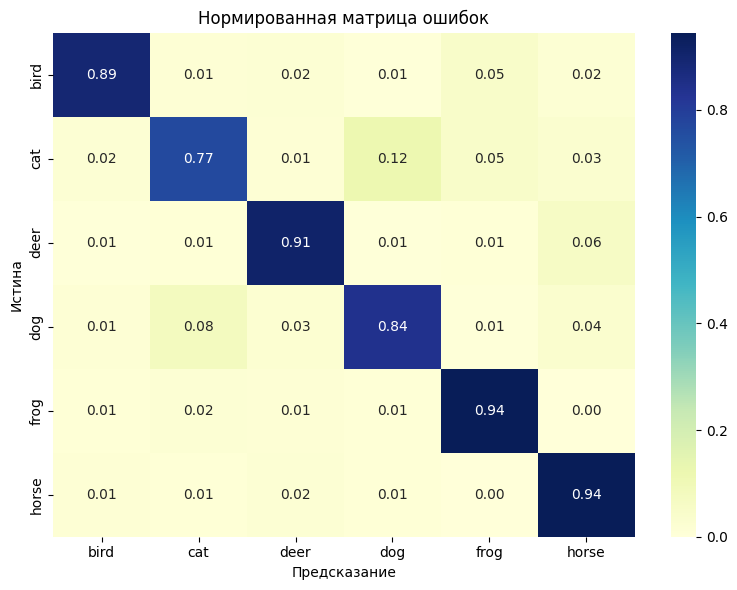

In [9]:
if best_path.exists():
    model.load_state_dict(torch.load(best_path, map_location=device))

all_preds, all_targets = [], []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, leave=False):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_targets.extend(labels.tolist())

all_preds_t = torch.tensor(all_preds)
all_targets_t = torch.tensor(all_targets)
test_accuracy = (all_preds_t == all_targets_t).float().mean().item()

print(f'Test accuracy: {test_accuracy:.4f}')
print('Классификационный отчёт:')
print(classification_report(all_targets, all_preds, target_names=animal_classes, digits=4))

cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(animal_classes))), normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=animal_classes, yticklabels=animal_classes)
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Нормированная матрица ошибок')
plt.tight_layout()
plt.show()


### Итоговые метрики
- Test accuracy: 0.8825
- Macro F1: 0.8816
- Precision: 0.8824
- Recall: 0.8825


## Примеры предсказаний
Несколько случайных картинок с теста, чтобы визуально понять, где модель ошибается.


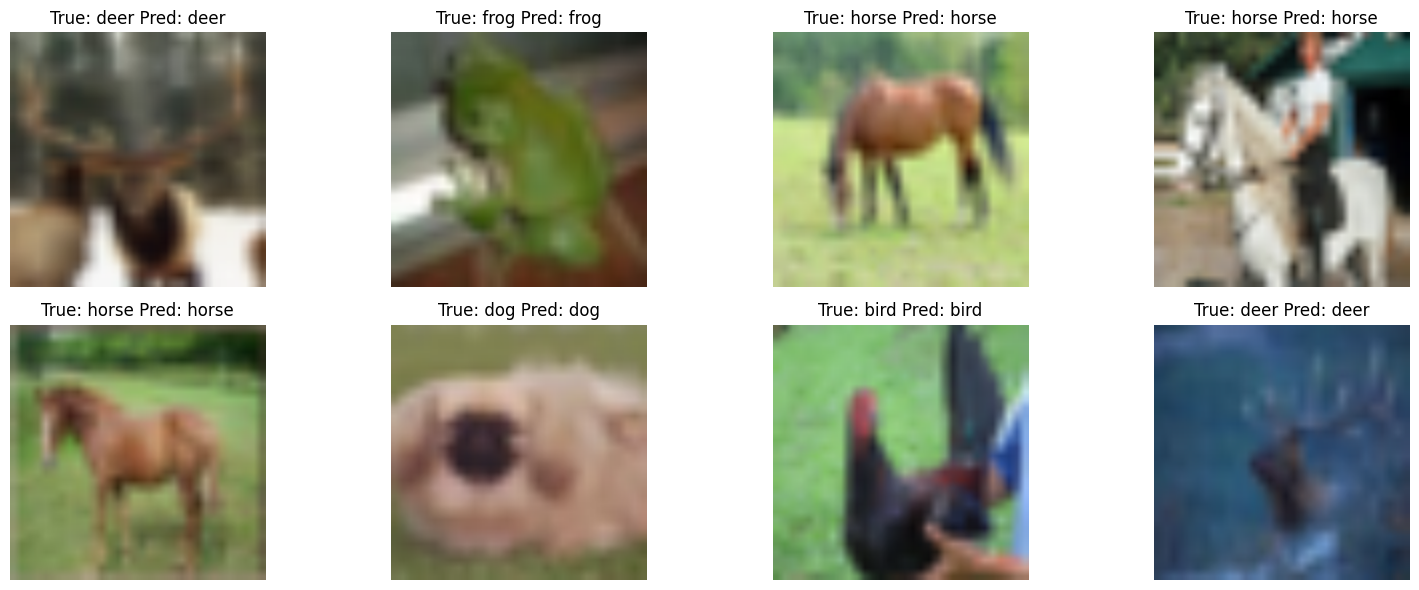

In [10]:
mean = torch.tensor(imagenet_mean).view(3, 1, 1)
std = torch.tensor(imagenet_std).view(3, 1, 1)

def denormalize(img_tensor):
    return img_tensor * std + mean

samples_to_show = 8
fig, axes = plt.subplots(2, samples_to_show // 2, figsize=(16, 6))
axes = axes.flatten()

model.eval()
with torch.no_grad():
    for ax in axes:
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        idx = random.randrange(images.size(0))
        img = denormalize(images[idx].cpu()).clamp(0, 1)
        true_label = animal_classes[labels[idx].item()]
        pred_label = animal_classes[preds[idx].item()]

        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        ax.set_title(f'True: {true_label} Pred: {pred_label}')

plt.tight_layout()
plt.show()


## Выводы
* Предобученный ResNet-18 быстро адаптируется к животным из CIFAR-10 даже при ограниченном числе примеров.
* Метрики и матрица ошибок показывают, какие классы путаются (обычно кошки/собаки, птицы/лягушки).
* Для лучшего качества можно увеличить `max_train_per_class`, добавить больше эпох и тонкую настройку learning rate.
